In [1]:
import yfinance as yf
import pandas as pd

# ticker = 'AAPL'  # apple
# data = yf.download(ticker, start='2025-01-01', end='2025-5-18', group_by='ticker')

# # Bỏ MultiIndex trong columns
# data.columns = data.columns.get_level_values(1)  # giữ lại chỉ tên cột (AAPL)

# data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# data.dropna(inplace=True)
# data.tail()

In [4]:
pip install ta

  Using cached ta-0.11.0.tar.gz (25 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29497 sha256=7b8d0de9fb695be0d90704bdbeb04c93c4c5288b2c75b7e22153869b4c5280ed
  Stored in directory: c:\users\madmo\appdata\local\pip\cache\wheels\61\d8\66\8018676d483fa5edb5337a7a25ee8c029ac255be25f90f3cd5
Successfully built ta
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
data = pd.read_csv("./data/stocks/INTC.csv", sep=',')

data['Date'] = pd.to_datetime(data['Date'])
data.index = range(len(data))

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.325521,0.330729,0.325521,0.325521,0.204750,10924800
1,1980-03-18,0.325521,0.328125,0.322917,0.322917,0.203112,17068800
2,1980-03-19,0.330729,0.335938,0.330729,0.330729,0.208026,18508800
3,1980-03-20,0.330729,0.334635,0.329427,0.329427,0.207207,11174400
4,1980-03-21,0.322917,0.322917,0.317708,0.317708,0.199836,12172800


In [3]:
# from ta.trend import SMAIndicator

# # Dam bao close_series la mot chieu
# close_series = data['Close']
# if isinstance(close_series, pd.DataFrame):
#     close_series = close_series.squeeze()

# data['MA5'] = SMAIndicator(close=close_series, window=5).sma_indicator()
# data['MA10'] = SMAIndicator(close=close_series, window=10).sma_indicator()
# data['RSI'] = RSIIndicator(close=close_series).rsi()
# data['MACD'] = MACD(close=close_series).macd()

# # Thêm cột giá thay đổi theo ngày
# data['PriceDiff'] = data['Close'].diff()
# data.dropna(inplace=True)

#===================================================================================================
from ta.trend import SMAIndicator, EMAIndicator, MACD, ADXIndicator
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands



# Đảm bảo 'Close' là Series 1 chiều
close_series = data['Close']
if isinstance(close_series, pd.DataFrame):
    close_series = close_series.squeeze()

# Các chỉ báo trung bình
data['MA5'] = SMAIndicator(close=close_series, window=5).sma_indicator()
data['MA10'] = SMAIndicator(close=close_series, window=10).sma_indicator()
data['EMA10'] = EMAIndicator(close=close_series, window=10).ema_indicator()

# Chỉ báo dao động
data['RSI'] = RSIIndicator(close=close_series).rsi()
data['Stoch_%K'] = StochasticOscillator(close=close_series, high=data['High'].squeeze(), low=data['Low'].squeeze()).stoch()
data['Stoch_%D'] = StochasticOscillator(close=close_series, high=data['High'].squeeze(), low=data['Low'].squeeze()).stoch_signal()

# MACD
macd = MACD(close=close_series)
data['MACD'] = macd.macd()
data['MACD_Signal'] = macd.macd_signal()
data['MACD_Diff'] = macd.macd_diff()

# Bollinger Bands
bb = BollingerBands(close=close_series)
data['BB_High'] = bb.bollinger_hband()
data['BB_Low'] = bb.bollinger_lband()
data['BB_Width'] = bb.bollinger_wband()

# ADX
adx = ADXIndicator(high=data['High'], low=data['Low'], close=close_series)
data['ADX'] = adx.adx()
data['+DI'] = adx.adx_pos()
data['-DI'] = adx.adx_neg()

# Giá thay đổi
data['PriceDiff'] = data['Close'].diff()

print
# Xóa các dòng NaN do chỉ báo tạo ra
data.dropna(inplace=True)


In [4]:
data['Target'] = data['Close'].shift(-1)
data.dropna(inplace=True)

features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'MA5', 'MA10', 'EMA10',
    'RSI', 'Stoch_%K', 'Stoch_%D',
    'MACD', 'MACD_Signal', 'MACD_Diff',
    'BB_High', 'BB_Low', 'BB_Width',
    'ADX', '+DI', '-DI',
    'PriceDiff'
]
X = data[features]
y = data['Target']

In [5]:
split_idx = int(len(data) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

model = RandomForestRegressor(n_estimators=500,max_depth=10, random_state=42, max_features="sqrt", min_samples_leaf=1, min_samples_split=2)
model.fit(X_train, y_train)

importances = model.feature_importances_
features = X_train.columns

y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print("RMSE:", rmse)

#======================================================================================
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Model ban đầu
# rf = RandomForestRegressor(random_state=42)

# # Tập tham số cần thử
# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Khởi tạo GridSearchCV
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv=3,  # số lần cross-validation
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1,  # chạy đa luồng cho nhanh
#     verbose=2  # in tiến trình
# )

# # Fit tìm tham số tốt nhất
# grid_search.fit(X_train, y_train)

# print("Best params:", grid_search.best_params_)
# print("Best CV RMSE:", -grid_search.best_score_)

# # Lấy model với tham số tốt nhất
# best_rf = grid_search.best_estimator_

# # Dự đoán trên test
# y_pred = best_rf.predict(X_test)

# # Tính RMSE trên test
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print("Test RMSE:", rmse)


RMSE: 1.0172259697444899


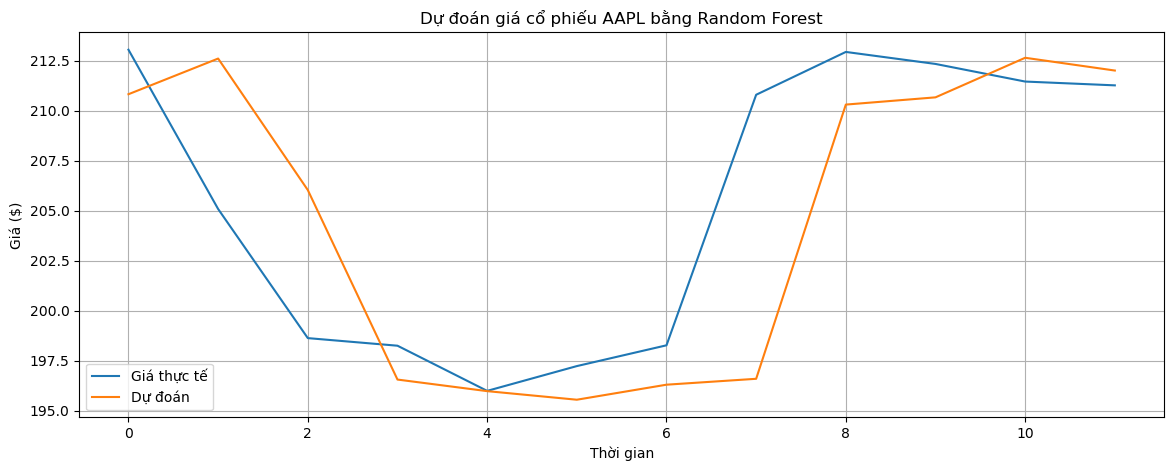

In [267]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test.values, label='Giá thực tế')
plt.plot(y_pred, label='Dự đoán')
plt.legend()
plt.title(f'Dự đoán giá cổ phiếu {ticker} bằng Random Forest')
plt.xlabel("Thời gian")
plt.ylabel("Giá ($)")
plt.grid()
plt.show()
# plt.figure(figsize=(10, 6))
# indices = np.argsort(importances)[::-1]
# plt.bar(range(len(importances)), importances[indices])
# plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45)
# plt.title("Feature Importances (Random Forest)")
# plt.tight_layout()
# plt.show()

In [268]:
latest_data = X.tail(1)
next_price = model.predict(latest_data)
print(f"Dự đoán giá cổ phiếu {ticker} ngày kế tiếp: ${next_price[0]:.2f}")

Dự đoán giá cổ phiếu AAPL ngày kế tiếp: $212.00
